## Modules

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from datetime import datetime, timedelta
from itertools import product

## Binary outcome & simulation: Arithmetic betting & risk-of-ruin

### Binary game simulation function

In [2]:
def getSim_binaryFixAmount(initAmount=100, a=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """
    Obtain dictionary of equal-amount-bet simulation results.
    initAmount: initial amount for betting
    f: percent per bet
    p: winning probability
    b: reward-to-risk ratio (/ odds)
    numTrialss: number of trials of the same binary game
    numSim: number of binary simulations
    """
    # Dict for recording different series of profit/loss
    simDict = {}
    # Dict for recording different series of capital (total equity)
    amountDict = {}
    # Generate a total of `numSim`= N series of binary game result and P/L
    stepFunc = lambda x: 1 if x > 0 else 0  # Lambda Function for getting "1" with a fixed prob and "0" otherwise
    for num in range(numSim):
        # Generate a series of "1"/"0" with probability p
        signArray = np.array([stepFunc(r) for r in np.random.uniform(p - 1, p, numTrials)])
        # Series of asset increment on win/loss result (EITHER increase by a * b OR decrease by a)
        trialArray = a * ((b + 1) * signArray - 1)
        # Record the asset increment series into `simDict`
        simDict[num + 1] = trialArray
        # Array of total equity and record into `amountDict`
        amountArray = initAmount + trialArray.cumsum()
        # IF equity drops below the fixed bet amount, stop betting
        period = 1
        while period <= numTrials - 1:
            if amountArray[period] < a:
                for j in range(period, numTrials):
                    amountArray[j] = amountArray[period]
                amountDict[f's{num}'] = amountArray
                break
            period += 1
        amountDict[f's{num + 1}'] = amountArray
    # Form dataframe from the `amountDict` and transpose, so that each row corresponds to a betting series
    dfSim = pd.DataFrame(amountDict).transpose()
    # Rename columns so that each number in column labels corresponds to the k-th trial
    dfSim = dfSim.rename(columns={k: (k + 1) for k in dfSim.columns})

    return dfSim

### Performance KPIs: winning rate, RRR (Realized reward-risk ratio), profit factor

In [3]:
def getProfitfactor(p, b):
    """Get profit factor of a binary game."""
    return round(p * b / (1 - p), 4)

def getOdds(p, pf):
    """Given fixed winning rate and profit factor, find odds (or reward-risk ratio)."""
    return pf * (1 - p) / p

def getWinrate(b, pf):
    """Given fixed odds and profit factor, find winning rate."""   
    return pf / (pf + b)

### Sample simulation: 20 trials, 30 simulations, converted into dataframe

In [4]:
initAmount0 = 100  # Initial capital
a0 = 20  # Fixed amount per bet
p0 = 0.5   # winning probability
b0 = 1.25   # reward-risk ratio / odds
numTrials0 = 10 # Number of trials
numSim0 = 20  # Number of simulations (how many people keep playing same game for 10 runs)

pf0 = round(getProfitfactor(p0, b0), 4)
print(f'Profit Factor = {pf0}')

dfSim0 = np.round(getSim_binaryFixAmount(initAmount0, a0, p0, b0, numTrials0, numSim0), 2)
dfSim0

Profit Factor = 1.25


,1,2,3,4,5,6,7,8,9,10
s1,80.0,105.0,85.0,65.0,45.0,25.0,5.0,5.0,5.0,5.0
s2,125.0,105.0,85.0,65.0,45.0,25.0,5.0,5.0,5.0,5.0
s3,125.0,105.0,85.0,65.0,45.0,25.0,5.0,5.0,5.0,5.0
s4,125.0,150.0,175.0,155.0,180.0,205.0,185.0,165.0,190.0,170.0
s5,125.0,150.0,175.0,155.0,135.0,115.0,140.0,120.0,100.0,125.0
s6,125.0,150.0,130.0,155.0,180.0,205.0,185.0,165.0,190.0,170.0
s7,125.0,105.0,85.0,110.0,90.0,115.0,140.0,120.0,145.0,125.0
s8,80.0,60.0,40.0,65.0,45.0,25.0,5.0,5.0,5.0,5.0
s9,80.0,60.0,40.0,65.0,45.0,25.0,5.0,5.0,5.0,5.0
s10,80.0,105.0,130.0,110.0,90.0,70.0,50.0,75.0,55.0,80.0


## Equity curve plotting

### Functions for simulation KPI & curve plotting

In [5]:
def getSimKPI_discretePL(simFunc, initAmount=100, f=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """Obtain a dictionary of final performance KPI of simulations. """
    dfSim = simFunc(initAmount, f, p, b, numTrials, numSim)
    dictKPI = {}
    dictKPI['p'] = p
    dictKPI['b'] = b
    dictKPI['f'] = f
    dictKPI['profitfactor'] = round(getProfitfactor(p, b), 4)
    dictKPI['win%'] = round(100 * dfSim[dfSim[numTrials] >= initAmount].shape[0] / numSim, 2)
    dictKPI['avgAmount'] = round(dfSim[numTrials].mean(), 2)
    dictKPI['midAmount'] = round(dfSim[numTrials].median(), 2)
    dictKPI['stdAmount'] = round(dfSim[numTrials].std(), 2)

    return dfSim, dictKPI

def plotSim_discretePL(simFunc, initAmount=100, a=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """Plot equity curves from the betting simulations."""
    # Dataframe and KPI dict from `getSimKPI_discretePL()` function
    dfSim, dictKPI = getSimKPI_discretePL(simFunc, initAmount, a, p, b, numTrials, numSim)
    # First line of diagram title
    title = f'{numSim} simulations of {numTrials}-step binary game \n'
    title += f'Winning rate {round(p, 4)}, odds {round(b, 4)}, ${a} per bet \n'

    # Percentage of final equity above or equal to initial amount
    winrate = dictKPI['win%']
    avgAmount = dictKPI['avgAmount']  # Arithmetic mean of final equity
    midAmount = dictKPI['midAmount']  # Median of final equity
    stdAmount = dictKPI['stdAmount']  # SD of final equity
    profitfactor = dictKPI['profitfactor']

    # Attach key stats to title text
    title += f'Profit factor: {profitfactor}, final winrate: {winrate}% \n'
    title += f'Final equity mean: {avgAmount}, median: {midAmount}, SD: {stdAmount}'

    # Plot figure & append title
    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(title, fontsize=12)

    # Transpose the equity dataframe to plot
    dfPlot = dfSim.transpose()
    plt.plot(dfPlot)
    plt.plot(dfPlot.index, np.repeat(initAmount, numTrials), color='black', linewidth=3, linestyle='dashed')
    plt.show()

### Standard sample: p = 0.4, b = 2.0

In [6]:
initAmount1 = 100  
a1 = 10  
p1 = 0.4   
b1 = 2.0   
numTrials1 = 50 
numSim1 = 1000  

dfSim1, dictKPI1 = getSimKPI_discretePL(getSim_binaryFixAmount, initAmount1, a1, p1, b1, numTrials1, numSim1)
dictKPI1

{'p': 0.4,
 'b': 2.0,
 'f': 10,
 'profitfactor': 1.3333,
 'win%': 75.6,
 'avgAmount': 178.13,
 'midAmount': 170.0,
 'stdAmount': 115.62}

### Curves of 1000 simulations of 50 trials

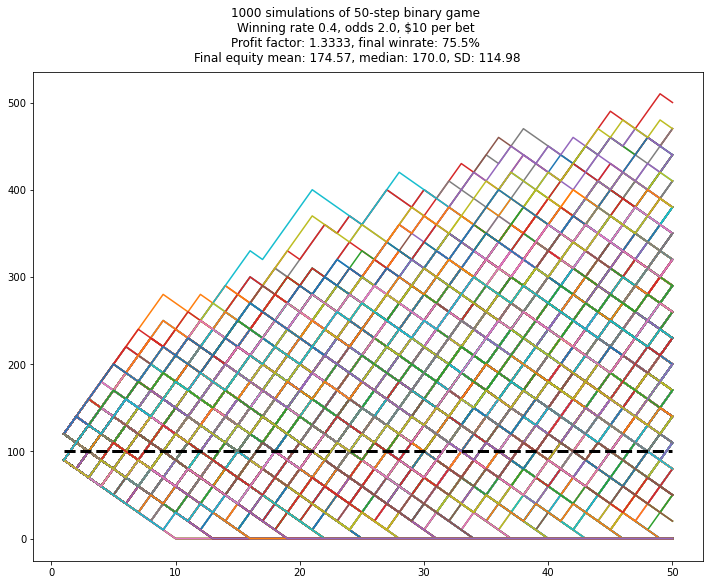

In [7]:
plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a1, p1, b1, numTrials1, numSim1)

### Raising winning rate & fix amount-per-bet, profit factor (odds reduced)

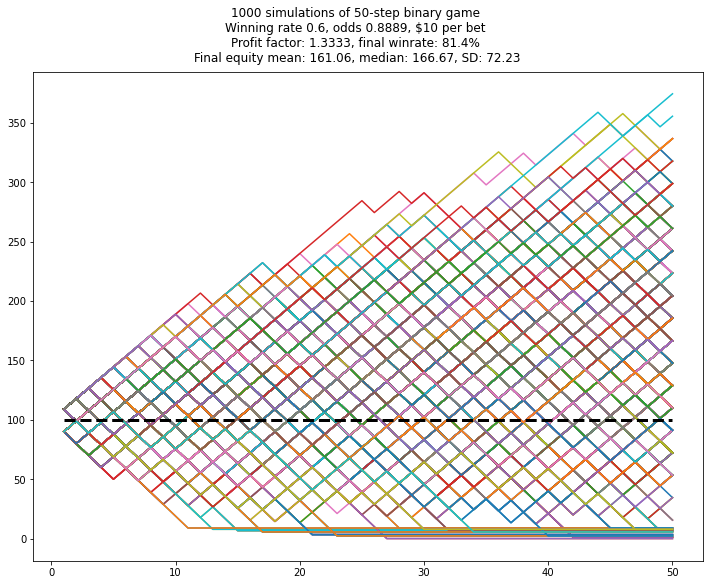

In [8]:
profitfactor1 = 4 / 3
p2 = 0.6   
b2 = getOdds(p2, profitfactor1)

plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a1, p2, b2, numTrials1, numSim1)

### Fix p & b, vary amount-per-bet

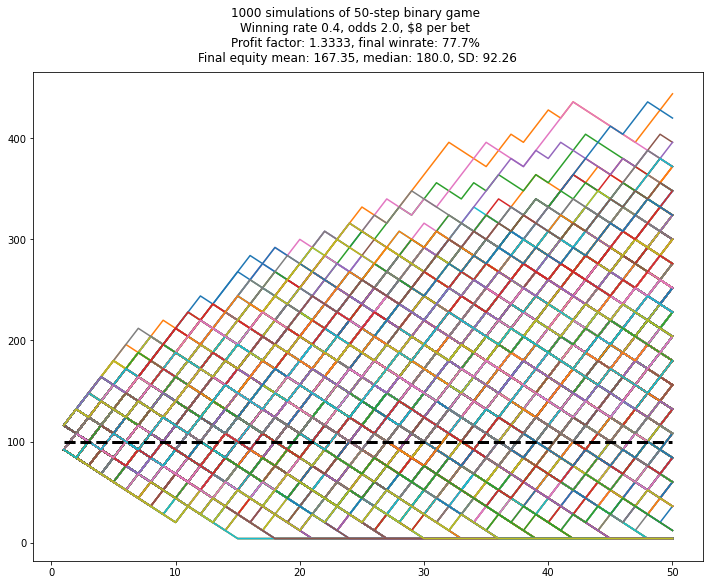

In [9]:
a2 = 8
plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a2, p1, b1, numTrials1, numSim1)

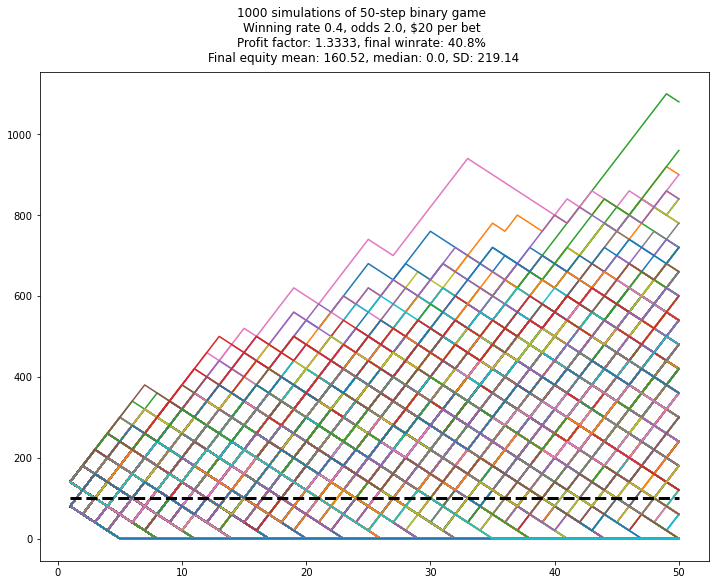

In [10]:
a3 = 20
plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a3, p1, b1, numTrials1, numSim1)

## Risk control & ruin

### Risk of ruin & MDD in a simulation

In [11]:
def getRuin(dfSim, initAmount=100, numTrial=50, level=0.1):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""   
    return dfSim[dfSim[numTrial] <= level*initAmount].shape[0] / dfSim.shape[0]

def getSimMDD(dfSim, levelsMDD=(0.2, 0.5, 0.8, 0.9)):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""
    # Transpose the simulation dataframe
    dfSimT = dfSim.transpose()
    numTrial = dfSim.shape[1]
    numSim = dfSim.shape[0]
    # Compute MDD
    dfMDD = pd.DataFrame(columns=dfSimT.columns)
    for col in dfSimT.columns:
        dfMDD[col] = (dfSimT[col] / dfSimT[col].cummax() - 1).cummin()
    # Tranpose back to match original shape
    dfMDD = dfMDD.transpose()
    # Compute percentage of simulations having MDD greater than the levels
    dictMDD = {}
    for value in levelsMDD:
        dictMDD[value] = dfMDD[dfMDD[numTrial] <= -value].shape[0] / numSim

    return dfMDD, dictMDD   

### Using above (p, b) pair and vary number of trials

In [12]:
trialsRange = range(50, 300, 50)  ## Number of betting trials from 50 to 250

for numTrials in trialsRange:
    dfSim = getSim_binaryFixAmount(initAmount1, a1, p1, b1, numTrials, 1000)
    ruin = getRuin(dfSim, initAmount1, numTrials, a1 / initAmount1)
    print(f'\n% of betting series with final equity below amount-per-bet ${a1} after {numTrials} trials: {ruin}\n')
    dfMDD, dictMDD = getSimMDD(dfSim)
    print(f'Percentage of betting series suffering \n')
    
    for key, value in dictMDD.items():
        print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')


% of betting series with final equity below amount-per-bet $10 after 50 trials: 0.157

Percentage of betting series suffering 

20% MDD: 93.2%
50% MDD: 48.2%
80% MDD: 21.4%
90% MDD: 17.1%

% of betting series with final equity below amount-per-bet $10 after 100 trials: 0.229

Percentage of betting series suffering 

20% MDD: 96.1%
50% MDD: 57.4%
80% MDD: 30.1%
90% MDD: 25.1%

% of betting series with final equity below amount-per-bet $10 after 150 trials: 0.26

Percentage of betting series suffering 

20% MDD: 97.7%
50% MDD: 59.4%
80% MDD: 33.4%
90% MDD: 28.9%

% of betting series with final equity below amount-per-bet $10 after 200 trials: 0.264

Percentage of betting series suffering 

20% MDD: 97.9%
50% MDD: 62.2%
80% MDD: 34.4%
90% MDD: 29.2%

% of betting series with final equity below amount-per-bet $10 after 250 trials: 0.27

Percentage of betting series suffering 

20% MDD: 98.0%
50% MDD: 61.2%
80% MDD: 31.9%
90% MDD: 28.8%


### Fix p, b and raise amount-per-bet to 20

In [13]:
for numTrials in trialsRange:
    dfSim = getSim_binaryFixAmount(initAmount1, a3, p1, b1, numTrials, 1000)
    ruin = getRuin(dfSim, initAmount1, numTrials, a3 / initAmount1)
    print(f'\n% of betting series with final equity below amount-per-bet ${a1} after {numTrials} trials: {ruin}\n')
    dfMDD, dictMDD = getSimMDD(dfSim)
    print(f'Percentage of betting series suffering \n')
    
    for key, value in dictMDD.items():
        print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')


% of betting series with final equity below amount-per-bet $10 after 50 trials: 0.5004995004995005

Percentage of betting series suffering 

20% MDD: 98.7%
50% MDD: 78.42%
80% MDD: 55.74%
90% MDD: 50.95%

% of betting series with final equity below amount-per-bet $10 after 100 trials: 0.597

Percentage of betting series suffering 

20% MDD: 99.6%
50% MDD: 85.2%
80% MDD: 65.8%
90% MDD: 61.2%

% of betting series with final equity below amount-per-bet $10 after 150 trials: 0.5864135864135864

Percentage of betting series suffering 

20% MDD: 99.4%
50% MDD: 84.52%
80% MDD: 63.64%
90% MDD: 59.74%

% of betting series with final equity below amount-per-bet $10 after 200 trials: 0.649

Percentage of betting series suffering 

20% MDD: 99.5%
50% MDD: 88.0%
80% MDD: 70.3%
90% MDD: 66.5%

% of betting series with final equity below amount-per-bet $10 after 250 trials: 0.6373626373626373

Percentage of betting series suffering 

20% MDD: 99.4%
50% MDD: 86.71%
80% MDD: 69.73%
90% MDD: 65.63%


## Fixed p = 0.5, 100 bets (2 year), 1000 sims, varied perbet amount and odds

### Simulations

In [14]:
bList = [0.25 * r for r in range(2, 13)]
aList = [25, 20, 15, 10, 5, 2]
initAmount = 100
p = 0.5
numTrials = 100
numSim = 1000

simDict = {}
dfProb1 = pd.DataFrame()  # Terminal winning probability
dfAvg1 = pd.DataFrame() # Average final P/L
dfStd1 = pd.DataFrame() # SD of final P/L
dfRuin1 = pd.DataFrame()  # Risk of ruin

for b, a in product(bList, aList):
    dfSim, kpiDict = getSimKPI_discretePL(getSim_binaryFixAmount, initAmount, a, p, b, numTrials, numSim)
    simDict[(p, b, a)] = dfSim
    dfProb1.loc[f'${a}', b] = kpiDict['win%']
    dfAvg1.loc[f'${a}', b] = kpiDict['avgAmount'] - initAmount
    dfStd1.loc[f'${a}', b] = kpiDict['stdAmount'] 
    dfRuin1.loc[f'${a}', b] = getRuin(dfSim, initAmount, numTrials, level=a / initAmount)

### Equity Curve plots: p = 0.5, b = 1.5, 10 dollars per bet

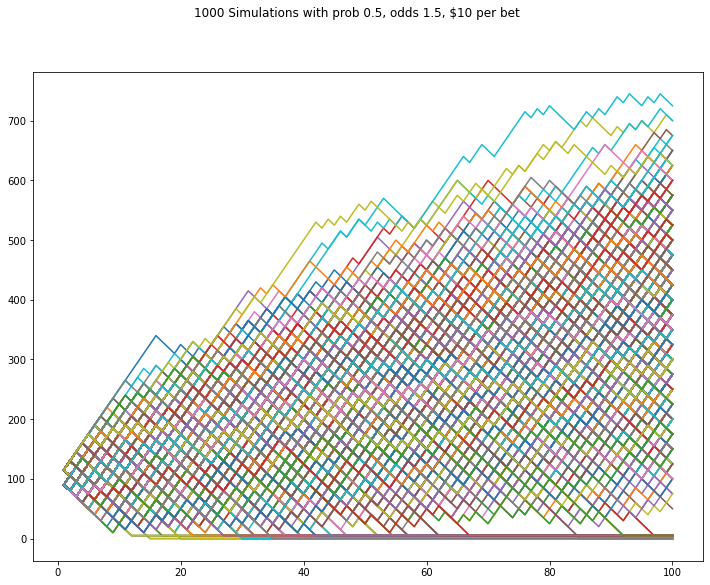

In [15]:
fig = plt.figure(figsize=(12, 9))
spec = (0.5, 1.5, 10)

fig.suptitle(f'1000 Simulations with prob {spec[0]}, odds {spec[1]}, ${spec[2]} per bet')
plt.plot(simDict[spec].transpose())
plt.show()

### Terminal winning probability

In [16]:
dfProb1[(dfAvg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,28.8,52.6,60.7,73.3,73.7,77.7,78.8,83.4
$20,NaN,NaN,NaN,38.3,62.9,70.3,80.6,83.3,85.0,87.3,91.3
$15,NaN,NaN,NaN,53.9,76.1,86.6,88.5,93.0,95.1,94.4,94.7
$10,NaN,NaN,NaN,68.2,91.5,96.6,97.6,99.2,99.0,99.6,99.8
$5,NaN,NaN,NaN,86.9,98.5,99.8,100.0,100.0,100.0,100.0,100.0
$2,NaN,NaN,54.4,88.7,98.7,99.5,100.0,100.0,100.0,100.0,100.0


### Average terminal P/L

In [17]:
dfAvg1[(dfAvg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,60.90,332.65,562.11,896.60,1160.83,1470.16,1730.83,2094.71
$20,NaN,NaN,NaN,81.85,311.67,530.88,797.52,1051.99,1278.75,1519.36,1832.26
$15,NaN,NaN,NaN,95.14,283.73,479.65,667.80,877.90,1066.71,1228.52,1415.55
$10,NaN,NaN,NaN,80.47,233.44,359.27,486.23,618.68,749.01,870.32,1010.32
$5,NaN,NaN,NaN,62.75,123.10,188.65,250.75,312.95,374.09,438.27,500.28
$2,NaN,NaN,0.3,25.57,51.01,76.06,102.73,123.34,149.98,174.39,197.96


### SD of terminal P/L

In [18]:
dfStd1[(dfAvg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,265.95,451.19,587.33,681.54,823.44,917.60,1030.12,1083.41
$20,NaN,NaN,NaN,248.45,361.45,460.53,509.98,584.15,663.11,703.98,710.22
$15,NaN,NaN,NaN,196.46,257.72,285.33,337.96,348.06,369.26,421.62,463.61
$10,NaN,NaN,NaN,136.72,151.02,159.29,170.94,173.69,193.72,199.41,203.48
$5,NaN,NaN,NaN,56.95,63.55,69.47,73.08,80.11,84.51,98.21,104.10
$2,NaN,NaN,19.61,21.49,25.12,27.69,29.12,32.63,34.66,36.10,39.80


### Risk-of-ruin

In [19]:
dfRuin1[(dfAvg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,0.707293,0.474525,0.393000,0.267,0.263,0.223,0.212,0.166833
$20,NaN,NaN,NaN,0.614000,0.371000,0.297702,0.194,0.167,0.150,0.127,0.087000
$15,NaN,NaN,NaN,0.441000,0.238761,0.133866,0.115,0.070,0.049,0.056,0.053000
$10,NaN,NaN,NaN,0.254000,0.081000,0.032000,0.024,0.008,0.010,0.004,0.002000
$5,NaN,NaN,NaN,0.012000,0.002000,0.000000,0.000,0.000,0.000,0.000,0.000000
$2,NaN,NaN,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000000


## Fixed odds = 1, 100 bets (2 year), 1000 sims, varied perbet amount and odds

### Simulations

In [20]:
pList = np.arange(0.25, 0.75, 0.05)
aList = [25, 20, 15, 10, 5, 2]
amountList = [f'${a}' for a in aList]

initAmount = 100
b = 1.0
numTrials = 100
numSim = 1000

simDict = {}
dfProb2 = pd.DataFrame()  # Terminal winning probability
dfAvg2 = pd.DataFrame() # Average final P/L
dfStd2 = pd.DataFrame() # SD of final P/L
dfRuin2 = pd.DataFrame()  # Risk of ruin

for p, a in product(pList, aList):
    dfSim, kpiDict = getSimKPI_discretePL(getSim_binaryFixAmount, initAmount, a, p, b, numTrials, numSim)
    simDict[(p, b, a)] = dfSim
    pct = round(100 * p)
    dfProb2.loc[f'${a}', f'{pct}%'] = kpiDict['win%']
    dfAvg2.loc[f'${a}', f'{pct}%'] = kpiDict['avgAmount'] - initAmount
    dfStd2.loc[f'${a}', f'{pct}%'] = kpiDict['stdAmount'] 
    dfRuin2.loc[f'${a}', f'{pct}%'] = getRuin(dfSim, initAmount, numTrials, level=a / initAmount)

### Probability of terminal winning 

In [21]:
dfProb2[(dfAvg2 > 0)]

,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%
$25,NaN,NaN,NaN,NaN,NaN,NaN,37.6,66.3,85.7,93.6
$20,NaN,NaN,NaN,NaN,NaN,NaN,46.2,75.4,91.4,94.0
$15,NaN,NaN,NaN,NaN,NaN,NaN,52.7,81.5,93.6,99.0
$10,NaN,NaN,NaN,NaN,NaN,NaN,72.8,96.1,99.2,100.0
$5,NaN,NaN,NaN,NaN,NaN,NaN,87.0,98.0,100.0,100.0
$2,NaN,NaN,NaN,NaN,NaN,55.0,85.9,98.0,100.0,100.0


### Average Terminal P/L

In [22]:
dfAvg2[(dfAvg2 > 0)]

,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%
$25,NaN,NaN,NaN,NaN,NaN,NaN,78.87,309.00,632.00,931.90
$20,NaN,NaN,NaN,NaN,NaN,NaN,79.40,300.70,551.92,747.60
$15,NaN,NaN,NaN,NaN,NaN,NaN,61.86,245.21,417.27,598.65
$10,NaN,NaN,NaN,NaN,NaN,NaN,66.78,186.10,300.26,402.88
$5,NaN,NaN,NaN,NaN,NaN,NaN,50.48,101.24,149.16,199.28
$2,NaN,NaN,NaN,NaN,NaN,0.46,19.33,39.85,60.18,79.57


### SD Terminal P/L

In [23]:
dfStd2[(dfAvg2 > 0)]

,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%
$25,NaN,NaN,NaN,NaN,NaN,NaN,261.78,344.07,363.46,347.39
$20,NaN,NaN,NaN,NaN,NaN,NaN,219.77,274.19,263.19,280.57
$15,NaN,NaN,NaN,NaN,NaN,NaN,167.12,200.25,193.32,149.91
$10,NaN,NaN,NaN,NaN,NaN,NaN,115.07,105.78,98.08,92.36
$5,NaN,NaN,NaN,NaN,NaN,NaN,51.16,48.17,46.88,45.58
$2,NaN,NaN,NaN,NaN,NaN,19.88,19.72,19.61,19.21,19.44


### Risk-of-ruin

In [24]:
dfRuin2[(dfAvg2 > 0)]

,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%
$25,NaN,NaN,NaN,NaN,NaN,NaN,0.617383,0.336000,0.143,0.064
$20,NaN,NaN,NaN,NaN,NaN,NaN,0.534000,0.243000,0.086,0.060
$15,NaN,NaN,NaN,NaN,NaN,NaN,0.455000,0.181818,0.064,0.010
$10,NaN,NaN,NaN,NaN,NaN,NaN,0.214000,0.032000,0.006,0.000
$5,NaN,NaN,NaN,NaN,NaN,NaN,0.004000,0.000000,0.000,0.000
$2,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000,0.000,0.000


## Fixed Profit Factor = 1.5, 104 bets, varied prob & per bet 

In [ ]:
oddslist = [0.25 * r for r in range(2, 13)]
amtlist = [25, 20, 12.5, 10, 8, 5, 4, 3, 2, 1]
dollist = [f'${amt}' for amt in amtlist]

base = 100
numtrials = 104
numsim = 1000
pfactor = 1.5

dfruin3 = pd.DataFrame(columns=oddslist, index=dollist)
dfplus3 = pd.DataFrame(columns=oddslist, index=dollist)
dfamtavg3 = pd.DataFrame(columns=oddslist, index=dollist)
dfamtstd3 = pd.DataFrame(columns=oddslist, index=dollist)


for odds, amt in product(oddslist, amtlist):
    p = pfactor / (odds + pfactor)
    dfbet, kpidict = getsimkpi(base, amt, p, odds, numtrials, numsim)
    betdict[(p, odds, amt)] = dfbet
    dfruin3.loc[f'${amt}', odds] = kpidict['ruin']
    dfplus3.loc[f'${amt}', odds] = kpidict['win%']  
    dfamtavg3.loc[f'${amt}', odds] = kpidict['P/Lavg'] 
    dfamtstd3.loc[f'${amt}', odds] = kpidict['P/Lstd'] 

### Risk-of-ruin

In [ ]:
dfruin3

In [ ]:
dfruin3[(dfruin3 < 0.01) & (dfamtavg3 > 0)]

### Terminal winning probabilities

In [ ]:
dfplus3

### Average Terminal P/L

In [ ]:
dfamtavg3[(dfruin3 < 0.01) & (dfamtavg3 > 0)]

### SD Terminal P/L

In [ ]:
dfamtstd3[(dfruin3 < 0.01) & (dfamtavg3 > 0)]